In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#for structured data we use Spark SQL, SparkSession acts a pipeline between data and sql statements
from pyspark.sql import SparkSession

In [3]:
# sparksession is like a class and we need to create an instance of a class to utilize
spark = SparkSession.builder.appName("K-Means_Clustering_Data_Processing").getOrCreate()

In [4]:
#Reading the csv file data
Uber_DF = spark.read.csv("/Users/sowjanyakoka/Desktop/Spring2020/MachineLearning/UberApril14.csv", inferSchema = True, header = True)

# Question1. What is the shape of the data contained in the UberApril14.CSV?

In [5]:

#Answer:
#==========================================================================
#Seeing the shape of the dataset
print("Shape:", (Uber_DF.count(), len(Uber_DF.columns)))

Shape: (564516, 4)


In [6]:
#Looking at the schema
Uber_DF.printSchema()

root
 |-- Date/Time: string (nullable = true)
 |-- Lat: double (nullable = true)
 |-- Lon: double (nullable = true)
 |-- Base: string (nullable = true)



# Question2. How many Uber trips were recorded for each company (by base code).

In [7]:

#Answer:
#=========================================================================
#Checking how many distinct companies are there in our data
Distinct_TLC_Codes = Uber_DF.select('Base').distinct().count()
print("Number of TLC base company codes affiliated with Uber pickup :", Distinct_TLC_Codes )

Number of TLC base company codes affiliated with Uber pickup : 5


In [8]:
print("Trips recorded for each company (by base code) :")
Uber_DF.groupBy('Base').count().orderBy('count',ascending = False).show()

Trips recorded for each company (by base code) :
+------+------+
|  Base| count|
+------+------+
|B02682|227808|
|B02598|183263|
|B02617|108001|
|B02512| 35536|
|B02764|  9908|
+------+------+



# Question2. What can you say about the distribution trips among companies? 

In [9]:

#B02682(Schmecken) is the first company that has highest(227808) distribution of trips
#B02598(Hinter LLC) is the second company with high(183263) distribution of trips
#B02617(Weiter) is the third company with high(108001) distribution of trips
#B02512(Unter LLC) company has less(35536) distribution of trips
#B02764(Danach-NY) company has least(9908) distribution of trips

In [10]:
#Looking at the descriptive statistics of the data set
Uber_DF.describe().show(truncate=False)

+-------+----------------+--------------------+-------------------+------+
|summary|Date/Time       |Lat                 |Lon                |Base  |
+-------+----------------+--------------------+-------------------+------+
|count  |564516          |564516              |564516             |564516|
|mean   |null            |40.74000520746969   |-73.97681683902599 |null  |
|stddev |null            |0.036083205020168534|0.05042582837278683|null  |
|min    |4/1/2014 0:00:00|40.0729             |-74.7733           |B02512|
|max    |4/9/2014 9:59:00|42.1166             |-72.0666           |B02764|
+-------+----------------+--------------------+-------------------+------+



# Question2. Are there companies that dominate in terms of the percentage share of the trips? 

In [11]:

#If consider the descriptive statastics above, we can see the total number of trips recorded are 564516
#B02682(Schmecken) percentage share can be calculated as (227808/564516)*100 = 40.35 percent
#B02598(Hinter LLC) percentage share can be calculated as (183263/564516)*100 = 32.46 percent
#B02617(Weiter) percentage share can be calculated as (108001/564516)*100 = 19.13 percent
#B02512(Unter LLC) percentage share can be calculated as (35536/564516)*100 = 6.29 percent
#B02764(Danach-NY) percentage share can be calculated as (9908/564516)*100 = 1.75 percent
#Yes, from above results, it can be observed that B02682(Schmecken) is taking up nearly 41% share of the trips followed by B02598(Hinter LLC) having 33% share, 
#together resulting in 75% share of the trips can be considered as the dominating companies

# Question3.What features (or attributes) are recorded for each Uber trip? 

In [12]:

#(Answer):The features recorded for each automobile can be known by the column names in the dataframe
UberTrip_Features = Uber_DF.columns
print("The features recorded for each Uber trip are :", UberTrip_Features)

The features recorded for each Uber trip are : ['Date/Time', 'Lat', 'Lon', 'Base']


In [13]:
#1.Timestamp of pickup(Categorical Type - (String datatype))
#2.Latitude of pickup location(Numerical Type - (Double datatype))
#3.Longitude of pickup location((Numerical Type - (Double datatype)))
#4.TLC base company code affiliated with Uber pickup(Categorical Type - (String datatype))

# Question3.Does any attribute require transformation because of data type requirements in Clustering? 
#If so, identify the feature and comment on the type of transformation required. Include these comments in your notebook.

In [14]:


#The input columns available to us are,
#Timestamp of pickup(String datatype)
#Latitude of pickup location(Double datatype)
#Longitude of pickup location(Double datatype)
#We are not considering a Base label column since it's an unsupervised machine learning technique)


In [15]:
#In case we consider the Timestamp as one of the input column in finding the cluster,
#It is better to transform the column before clustering because K-means clustering is a type of unsupervised learning,
#which is used when we have unlabeled data (i.e., data without defined categories or groups)  as,
#it uses a distance measurement to calculate the similarity between observations
#but we need to understand that it does not make a lot of sense to calculate distance between binary variables.

In [16]:
#Checking for how many distinct time stamps are there in our data
Distinct_Timestamps = Uber_DF.select('Date/Time').distinct().count()
print("Number distinct timestamps in our data are:", Distinct_Timestamps )

Number distinct timestamps in our data are: 41999


In [17]:
#New dataframe for performing transformations
Transform_Uber_DF = Uber_DF

In [18]:
print(Transform_Uber_DF.count(), len(Transform_Uber_DF.columns))

564516 4


In [19]:
#In order to use the column for clustering we need to perform transformation
#The Date/Time variable has 41999 different Timestamps in complete dataset of 564516 records,
#We need to first transform the variable using a string indexer as it is of string datatype and then,
#Then generate dummy variables using one hot encoder to create a significant dummy vector varibles 
#Because Dummy variables carry good interpretation as it indicates either presence or absence of that attribute


In [20]:
#To assign dummy values to the string variables
from pyspark.ml.feature import StringIndexer
#For creation of a vector of input variables
from pyspark.ml.feature import VectorAssembler
#For assigning the dummy variables
from pyspark.ml.feature import OneHotEncoder

# Question4.Perform the transformations, if any, identified in step # 3. 

In [21]:

#Categorical values into numerical values
#StringIndexer arguments = name of input columns and resulting column
Timestamp_Indexer = StringIndexer(inputCol = 'Date/Time', outputCol = 'Date/Time_Num').fit(Transform_Uber_DF)
#Taking Categorical data and transforming
Transform_Uber_DF = Timestamp_Indexer.transform(Transform_Uber_DF)
#Checking if numbers are assingned
Transform_Uber_DF.show(5)

+----------------+-------+--------+------+-------------+
|       Date/Time|    Lat|     Lon|  Base|Date/Time_Num|
+----------------+-------+--------+------+-------------+
|4/1/2014 0:11:00| 40.769|-73.9549|B02512|      30757.0|
|4/1/2014 0:17:00|40.7267|-74.0345|B02512|      37044.0|
|4/1/2014 0:21:00|40.7316|-73.9873|B02512|      32573.0|
|4/1/2014 0:28:00|40.7588|-73.9776|B02512|      36872.0|
|4/1/2014 0:33:00|40.7594|-73.9722|B02512|      33766.0|
+----------------+-------+--------+------+-------------+
only showing top 5 rows



In [22]:
#To check count of data by Timestamp after creating Date/Time_Num
Transform_Uber_DF.groupBy('Date/Time_Num').count().show(truncate = False)

+-------------+-----+
|Date/Time_Num|count|
+-------------+-----+
|26615.0      |9    |
|7313.0       |22   |
|12493.0      |17   |
|13533.0      |16   |
|24801.0      |10   |
|7487.0       |22   |
|20948.0      |12   |
|14285.0      |16   |
|11935.0      |18   |
|27352.0      |8    |
|28553.0      |8    |
|10924.0      |18   |
|3597.0       |28   |
|9923.0       |19   |
|17884.0      |13   |
|1051.0       |36   |
|496.0        |41   |
|596.0        |40   |
|934.0        |37   |
|36504.0      |3    |
+-------------+-----+
only showing top 20 rows



In [23]:
#Check how many distinct values the variables have and assign right number of dummy variables for Date/Time
TimeStamp_Encoder = OneHotEncoder(inputCol = 'Date/Time_Num', outputCol = 'Date/Time_Dummy_Vector')
Transform_Uber_DF = TimeStamp_Encoder.transform(Transform_Uber_DF)
Transform_Uber_DF.show(10,truncate = False)

+----------------+-------+--------+------+-------------+----------------------+
|Date/Time       |Lat    |Lon     |Base  |Date/Time_Num|Date/Time_Dummy_Vector|
+----------------+-------+--------+------+-------------+----------------------+
|4/1/2014 0:11:00|40.769 |-73.9549|B02512|30757.0      |(41998,[30757],[1.0]) |
|4/1/2014 0:17:00|40.7267|-74.0345|B02512|37044.0      |(41998,[37044],[1.0]) |
|4/1/2014 0:21:00|40.7316|-73.9873|B02512|32573.0      |(41998,[32573],[1.0]) |
|4/1/2014 0:28:00|40.7588|-73.9776|B02512|36872.0      |(41998,[36872],[1.0]) |
|4/1/2014 0:33:00|40.7594|-73.9722|B02512|33766.0      |(41998,[33766],[1.0]) |
|4/1/2014 0:33:00|40.7383|-74.0403|B02512|33766.0      |(41998,[33766],[1.0]) |
|4/1/2014 0:39:00|40.7223|-73.9887|B02512|36372.0      |(41998,[36372],[1.0]) |
|4/1/2014 0:45:00|40.762 |-73.979 |B02512|38203.0      |(41998,[38203],[1.0]) |
|4/1/2014 0:55:00|40.7524|-73.996 |B02512|34175.0      |(41998,[34175],[1.0]) |
|4/1/2014 1:01:00|40.7575|-73.9846|B0251

In [24]:
#To check count of data by Timestamp after creating Date/Time_Dummy_Vector
Transform_Uber_DF.groupBy('Date/Time_Dummy_Vector').count().show()

+----------------------+-----+
|Date/Time_Dummy_Vector|count|
+----------------------+-----+
|  (41998,[26832],[1...|    8|
|  (41998,[9879],[1.0])|   19|
|  (41998,[12365],[1...|   17|
|  (41998,[16814],[1...|   14|
|  (41998,[6298],[1.0])|   24|
|  (41998,[14387],[1...|   16|
|  (41998,[6010],[1.0])|   24|
|  (41998,[1918],[1.0])|   33|
|  (41998,[18803],[1...|   13|
|  (41998,[6261],[1.0])|   24|
|  (41998,[2429],[1.0])|   31|
|  (41998,[2843],[1.0])|   30|
|  (41998,[6338],[1.0])|   24|
|  (41998,[9105],[1.0])|   20|
|  (41998,[25408],[1...|    9|
|  (41998,[31616],[1...|    6|
|  (41998,[21030],[1...|   11|
|  (41998,[26184],[1...|    9|
|  (41998,[12685],[1...|   17|
|  (41998,[7292],[1.0])|   22|
+----------------------+-----+
only showing top 20 rows



# Question4. Perform feature engineering if and where needed, including vectorization of relevant variables. 

In [25]:

#As the model to be developed is a set of clusters to group trips by pickup location (longitude and latitude of the pickup location),
#we do not consider the Date/Time column for feature engineering
#Creating Dataframe for clustering
Cluster_DF = Uber_DF.drop('Date/Time')


In [26]:
Cluster_DF.show()

+-------+--------+------+
|    Lat|     Lon|  Base|
+-------+--------+------+
| 40.769|-73.9549|B02512|
|40.7267|-74.0345|B02512|
|40.7316|-73.9873|B02512|
|40.7588|-73.9776|B02512|
|40.7594|-73.9722|B02512|
|40.7383|-74.0403|B02512|
|40.7223|-73.9887|B02512|
| 40.762| -73.979|B02512|
|40.7524| -73.996|B02512|
|40.7575|-73.9846|B02512|
|40.7256|-73.9869|B02512|
|40.7591|-73.9684|B02512|
|40.7271|-73.9803|B02512|
|40.6463|-73.7896|B02512|
|40.7564|-73.9167|B02512|
|40.7666|-73.9531|B02512|
| 40.758|-73.9761|B02512|
|40.7238|-73.9821|B02512|
|40.7531|-74.0039|B02512|
|40.7389|-74.0393|B02512|
+-------+--------+------+
only showing top 20 rows



In [27]:
#####Feature Engineering######
#Loading packages for vectorization
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler

In [28]:
#specifying the input columns
input_cols=['Lat', 'Lon']

In [29]:
#Vector Assembling
vec_assembler = VectorAssembler(inputCols = input_cols, outputCol = 'features')

In [30]:
# Making a transformation
Final_Uber_DF = vec_assembler.transform(Cluster_DF)

# Question4.Provide a printout of the schema of your feature-engineered data.

In [31]:

#Checking schema for feature-engineered data
Final_Uber_DF.printSchema()

root
 |-- Lat: double (nullable = true)
 |-- Lon: double (nullable = true)
 |-- Base: string (nullable = true)
 |-- features: vector (nullable = true)



In [32]:
#Question5.To train and then test your model, split the data from UberApril14 into training and test datasets using a 75/25 split.
Model_DF = Final_Uber_DF.select(['Base','features'])

In [33]:
Model_DF.show(truncate = False)

+------+------------------+
|Base  |features          |
+------+------------------+
|B02512|[40.769,-73.9549] |
|B02512|[40.7267,-74.0345]|
|B02512|[40.7316,-73.9873]|
|B02512|[40.7588,-73.9776]|
|B02512|[40.7594,-73.9722]|
|B02512|[40.7383,-74.0403]|
|B02512|[40.7223,-73.9887]|
|B02512|[40.762,-73.979]  |
|B02512|[40.7524,-73.996] |
|B02512|[40.7575,-73.9846]|
|B02512|[40.7256,-73.9869]|
|B02512|[40.7591,-73.9684]|
|B02512|[40.7271,-73.9803]|
|B02512|[40.6463,-73.7896]|
|B02512|[40.7564,-73.9167]|
|B02512|[40.7666,-73.9531]|
|B02512|[40.758,-73.9761] |
|B02512|[40.7238,-73.9821]|
|B02512|[40.7531,-74.0039]|
|B02512|[40.7389,-74.0393]|
+------+------------------+
only showing top 20 rows



In [34]:
#Splitting of data for clustering into required division
Train_DF, Test_DF = Model_DF.randomSplit([0.75,0.25])

In [35]:
#Question5.Like you did in step 2 above, comment on the percentage distribution of trips among companies in both the training and test datasets.
print(Train_DF.count())

423827


In [36]:
#Checking how many distinct companies are there in our data
Train_Distinct_TLC_Codes = Train_DF.select('Base').distinct().count()
print("Number of TLC base company codes affiliated with Uber pickup in Training Dataset :", Distinct_TLC_Codes )

Number of TLC base company codes affiliated with Uber pickup in Training Dataset : 5


In [37]:
#
print("Trips recorded for each company (by base code) in Training Data :")
Train_DF.groupBy('Base').count().orderBy('count',ascending = False).show(truncate = False)

Trips recorded for each company (by base code) in Training Data :
+------+------+
|Base  |count |
+------+------+
|B02682|170957|
|B02598|137880|
|B02617|80889 |
|B02512|26670 |
|B02764|7431  |
+------+------+



In [38]:
#B02682(Schmecken) is the first company that has highest(170859) distribution of trips
#B02598(Hinter LLC) is the second company with high(137578) distribution of trips
#B02617(Weiter) is the third company with high(80777) distribution of trips
#B02512(Unter LLC) company has less(26668) distribution of trips
#B02764(Danach-NY) company has least(7375) distribution of trips

In [39]:
print(Test_DF.count())

140689


In [40]:
#Checking how many distinct companies are there in our data
Test_Distinct_TLC_Codes = Test_DF.select('Base').distinct().count()
print("Number of TLC base company codes affiliated with Uber pickup in Testing Dataset :", Distinct_TLC_Codes )

Number of TLC base company codes affiliated with Uber pickup in Testing Dataset : 5


In [41]:
#
print("Trips recorded for each company (by base code) in Testing Data :")
Test_DF.groupBy('Base').count().orderBy('count',ascending = False).show(truncate = False)

Trips recorded for each company (by base code) in Testing Data :
+------+-----+
|Base  |count|
+------+-----+
|B02682|56851|
|B02598|45383|
|B02617|27112|
|B02512|8866 |
|B02764|2477 |
+------+-----+



In [42]:
#B02682(Schmecken) is the first company that has highest(56949) distribution of trips
#B02598(Hinter LLC) is the second company with high(45685) distribution of trips
#B02617(Weiter) is the third company with high(27224) distribution of trips
#B02512(Unter LLC) company has less(8868) distribution of trips
#B02764(Danach-NY) company has least(2511) distribution of trips

# Question5.Are they representative of the overall data? Include your answer as comments in the notebook.

In [43]:

#Yes, they are representative of overall data because the original data has,
#If consider the descriptive statastics above, we can see the total number of trips recorded are 564516
#B02682(Schmecken) percentage share can be calculated as (227808/564516)*100 = 40.35 percent
#B02598(Hinter LLC) percentage share can be calculated as (183263/564516)*100 = 32.46 percent
#B02617(Weiter) percentage share can be calculated as (108001/564516)*100 = 19.13 percent
#B02512(Unter LLC) percentage share can be calculated as (35536/564516)*100 = 6.29 percent
#B02764(Danach-NY) percentage share can be calculated as (9908/564516)*100 = 1.75 percent
#Yes, from above results, it can be observed that B02682(Schmecken) is taking up nearly 41% share of the trips followed by B02598(Hinter LLC) having 33% share, 
#together resulting in 75% share of the trips can be considered as the dominating companies


# Question6.Build and train KMeans Clustering model. 

In [44]:

#Loading Kmeans from pyspark
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Question6. For this you, will use the Elbow method to identify the number of clusters to start the algorithm.

In [45]:
 #Use a seed value to ensure each iteration starts with the same initial set of conditions. 
errors = []
for k in range(2,10):
    #Setting seed value as 1
    kmeans = KMeans(featuresCol = 'features',k=k).setSeed(1)
    #trainig the model
    model = kmeans.fit(Train_DF)
    #defining intra cluster distance
    intra_cluster_distance = model.computeCost(Train_DF)
    #adding theSSes to the list we have taken
    errors.append(intra_cluster_distance)
    #taking each cluster and printing errors
    print("With K={}".format(k))#selection of cluster
    #Printing the error
    print("the sse = " + str(intra_cluster_distance))
    #Seperating the output errors and coefficients by dashes
    print("---"*20)
    

With K=2
the sse = 1020.1425193554632
------------------------------------------------------------
With K=3
the sse = 936.6312904709013
------------------------------------------------------------
With K=4
the sse = 630.5608120664851
------------------------------------------------------------
With K=5
the sse = 572.9671476925705
------------------------------------------------------------
With K=6
the sse = 458.50532836857263
------------------------------------------------------------
With K=7
the sse = 308.88755934701015
------------------------------------------------------------
With K=8
the sse = 272.77780005337684
------------------------------------------------------------
With K=9
the sse = 273.8542531570577
------------------------------------------------------------


# Question6.For this you, will use the Elbow method to identify the number of clusters to start the algorithm. 

In [46]:

#Use a seed value to ensure each iteration starts with the same initial set of conditions. 
#Experiment with (n-1) and (n+1) number of clusters, where n is the optimal number found by the Elbow method. 
#For each run, generate the SSE and Silhouette Coefficient. 
#Select the best model on the basis of SSE and Silhouette Coefficient. 

In [47]:
##Loading the packages for plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

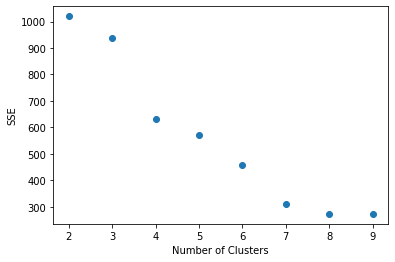

In [48]:
#Horizontal axis cluster number
#Plotting the cluster
cluster_number = range(2,10)
#Xlabel
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
#Using scatterplot
plt.scatter(cluster_number, errors)
plt.show()

In [49]:
#Above we can see Elbow curve occuring at cluster, K=6

In [50]:
from pyspark.ml.evaluation import ClusteringEvaluator
#Training the model with K=6 again
kmeans = KMeans(featuresCol = 'features',k=6).setSeed(1)
    #trainig the model
model_6 = kmeans.fit(Train_DF)

In [51]:
#Generating the predictions
K_6_predictions = model_6.transform(Train_DF)
K_6_predictions.columns

['Base', 'features', 'prediction']

In [52]:
#Seeing the prediction
K_6_predictions.groupBy('prediction').count().show()

+----------+------+
|prediction| count|
+----------+------+
|         1| 10732|
|         3| 15223|
|         5|171836|
|         4| 44998|
|         2|   731|
|         0|180307|
+----------+------+



In [53]:
#checking with TLC codes names
K_6_predictions.groupBy('prediction','Base').count().show(40,truncate = False)

+----------+------+-----+
|prediction|Base  |count|
+----------+------+-----+
|1         |B02512|539  |
|3         |B02682|6141 |
|4         |B02598|15548|
|5         |B02682|69578|
|2         |B02512|49   |
|1         |B02682|4371 |
|5         |B02764|2840 |
|3         |B02764|235  |
|1         |B02617|2174 |
|2         |B02598|258  |
|1         |B02764|177  |
|0         |B02682|72577|
|0         |B02617|34961|
|0         |B02512|11271|
|3         |B02617|3072 |
|5         |B02512|12418|
|3         |B02512|978  |
|2         |B02682|299  |
|5         |B02598|55723|
|2         |B02764|16   |
|3         |B02598|4797 |
|4         |B02764|748  |
|0         |B02764|3415 |
|4         |B02682|17991|
|2         |B02617|109  |
|0         |B02598|58083|
|4         |B02617|9296 |
|1         |B02598|3471 |
|4         |B02512|1415 |
|5         |B02617|31277|
+----------+------+-----+



In [54]:
#Clustering evaluation function K=6
evaluatorObj = ClusteringEvaluator()
#Evaluating the predictions for silhouette coefficient
silhouette_coeff_6 = evaluatorObj.evaluate(K_6_predictions)
#Printing Silhouette Coefficient
print('Silhouette Coefficient of K = 6 : '+ str(silhouette_coeff_6))

Silhouette Coefficient of K = 6 : 0.5077772061022856


In [55]:
#Experimenting for n-1
from pyspark.ml.evaluation import ClusteringEvaluator
kmeans = KMeans(featuresCol = 'features',k=5).setSeed(1)
    #trainig the model
model_5 = kmeans.fit(Train_DF)

In [56]:
#Generating the predictions
K_5_predictions = model_5.transform(Train_DF)
K_5_predictions.columns

['Base', 'features', 'prediction']

In [57]:
#Seeing the prediction
K_5_predictions.groupBy('prediction').count().show()

+----------+------+
|prediction| count|
+----------+------+
|         1| 11881|
|         3| 45283|
|         4|   910|
|         2|160513|
|         0|205240|
+----------+------+



In [58]:
#checking with TLC codes names
K_5_predictions.groupBy('prediction','Base').count().show(40,truncate = False)

+----------+------+-----+
|prediction|Base  |count|
+----------+------+-----+
|1         |B02512|597  |
|3         |B02682|18122|
|4         |B02598|312  |
|2         |B02512|11743|
|1         |B02682|4843 |
|3         |B02764|750  |
|1         |B02617|2402 |
|2         |B02598|51863|
|1         |B02764|201  |
|0         |B02682|82743|
|0         |B02617|39570|
|0         |B02512|12841|
|3         |B02617|9342 |
|3         |B02512|1425 |
|2         |B02682|64887|
|2         |B02764|2594 |
|3         |B02598|15644|
|4         |B02764|23   |
|0         |B02764|3863 |
|4         |B02682|362  |
|2         |B02617|29426|
|0         |B02598|66223|
|4         |B02617|149  |
|1         |B02598|3838 |
|4         |B02512|64   |
+----------+------+-----+



In [59]:
#Clustering evaluation function K=5
evaluatorObj = ClusteringEvaluator()
#Evaluating the predictions for silhouette coefficient
silhouette_coeff_5 = evaluatorObj.evaluate(K_5_predictions)
#Printing Silhouette Coefficient
print('Silhouette Coefficient of K = 5 : '+ str(silhouette_coeff_5))

Silhouette Coefficient of K = 5 : 0.5050605796502464


In [60]:
#Experimenting for n+1
from pyspark.ml.evaluation import ClusteringEvaluator
#Training the model with K=6 again
#Training the model with K=6 again
kmeans = KMeans(featuresCol = 'features',k=7).setSeed(1)
    #trainig the model
model_7 = kmeans.fit(Train_DF)

In [61]:
#Generating the predictions
K_7_predictions = model_7.transform(Train_DF)
K_7_predictions.columns

['Base', 'features', 'prediction']

In [62]:
#Seeing the prediction
K_7_predictions.groupBy('prediction').count().show()

+----------+------+
|prediction| count|
+----------+------+
|         1| 10709|
|         6|   735|
|         3|162372|
|         5| 44957|
|         4|  3628|
|         2| 14671|
|         0|186755|
+----------+------+



In [63]:
#checking with TLC codes names
K_7_predictions.groupBy('prediction','Base').count().show(40,truncate = False)

+----------+------+-----+
|prediction|Base  |count|
+----------+------+-----+
|1         |B02512|538  |
|3         |B02682|65771|
|4         |B02598|925  |
|5         |B02682|17961|
|2         |B02512|951  |
|1         |B02682|4360 |
|6         |B02617|111  |
|5         |B02764|746  |
|3         |B02764|2659 |
|1         |B02617|2165 |
|2         |B02598|4603 |
|1         |B02764|176  |
|6         |B02682|309  |
|0         |B02682|75268|
|6         |B02764|16   |
|0         |B02617|36193|
|0         |B02512|11380|
|3         |B02617|29461|
|5         |B02512|1410 |
|3         |B02512|11822|
|2         |B02682|5910 |
|5         |B02598|15545|
|2         |B02764|231  |
|6         |B02598|250  |
|6         |B02512|49   |
|3         |B02598|52659|
|4         |B02764|117  |
|0         |B02764|3486 |
|4         |B02682|1378 |
|2         |B02617|2976 |
|0         |B02598|60428|
|4         |B02617|688  |
|1         |B02598|3470 |
|4         |B02512|520  |
|5         |B02617|9295 |
+----------+

In [64]:
#Clustering evaluation function K=7
evaluatorObj = ClusteringEvaluator()
#Evaluating the predictions for silhouette coefficient
silhouette_coeff_7 = evaluatorObj.evaluate(K_7_predictions)
#Printing Silhouette Coefficient
print('Silhouette Coefficient of K = 7 : '+ str(silhouette_coeff_7))

Silhouette Coefficient of K = 7 : 0.6312335452401061


# Question7.Using the best trained model from step 6, test the performance of the model against the test dataset. 

In [66]:
kmeans = KMeans(featuresCol='features',k=6).setSeed(1)
model = kmeans.fit(Test_DF)
model.transform(Test_DF).groupBy('prediction','Base').count().show(50, truncate = False)
SSE = model.computeCost(Test_DF)
predictions = model.transform(Test_DF)
silhouette_coeff = evaluatorObj.evaluate(predictions)
print("the sse = " + str(SSE))
print('Silhouette Coefficient : '+ str(silhouette_coeff))

+----------+------+-----+
|prediction|Base  |count|
+----------+------+-----+
|1         |B02512|337  |
|3         |B02682|74   |
|4         |B02598|21735|
|5         |B02682|88   |
|2         |B02512|174  |
|1         |B02682|2133 |
|5         |B02764|3    |
|3         |B02764|5    |
|1         |B02617|1111 |
|2         |B02598|1132 |
|1         |B02764|76   |
|0         |B02682|25732|
|0         |B02617|11563|
|0         |B02512|4471 |
|3         |B02617|25   |
|5         |B02512|19   |
|3         |B02512|11   |
|2         |B02682|1441 |
|5         |B02598|89   |
|2         |B02764|49   |
|3         |B02598|64   |
|4         |B02764|1240 |
|0         |B02764|1104 |
|4         |B02682|27383|
|2         |B02617|703  |
|0         |B02598|20662|
|4         |B02617|13659|
|1         |B02598|1701 |
|4         |B02512|3854 |
|5         |B02617|51   |
+----------+------+-----+

the sse = 179.71791133890045
Silhouette Coefficient : 0.4465287996232673


In [67]:
#The model has an accuracy of about 56% as the Silhouette Coefficienthigh value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.
#Silhouette coefficients near +1 indicate that the object is far away from the neighboring clusters
#But we cant tell it is the best model as our data in both test and original data is unequally distributed by few dominatinting comanies

In [68]:
#|B02682|227808|, Most of the highest trips company are in cluster 0,2 for test dataset prediction
#|B02598|183263|,Most of the highest trips company are in cluster 0,2 for test dataset prediction
#|B02617|108001|,Most of the highest trips company are in cluster 0,2 for test dataset prediction
#|B02512| 35536|,2
#|B02764|  9908,2

In [69]:
#Converting prdictions into a pandas dataframe(because gives tabulated result)
pandas_df = predictions.toPandas()
pandas_df.head()

,Base,features,prediction
0,B02512,"[40.5111, -74.3281]",4
1,B02512,"[40.5277, -74.3991]",4
2,B02512,"[40.5445, -74.155]",4
3,B02512,"[40.5613, -74.475]",4
4,B02512,"[40.5783, -73.9567]",4


# Question 8. Do your own research on evaluation metrics, other than the Silhouette Coefficient, that may be used to measure the performance of the KMeans Clustering algorithm as implemented by pyspark’s MLlib in python. You may want to see how your final model performs on these other metrics. 

In [71]:
#The other excellent metrics for determining the true count of the clusters such as Bayesian Information Criterion (BIC) but it can be applied only if we are willing to extend the clustering algorithm beyond k-means to the more generalized version — Gaussian Mixture Model (GMM)